---
# <h1 style="color:olive;"><b>1 - Library</b></h1>

In [ ]:
#!pip install opencv-python numpy face_recognition face_recognition_models scikit-image deepface mediapipe

In [ ]:
#!pip install matplotlib diffusers transformers accelerate safetensors torch pillow

In [2]:
!python --version

Python 3.10.19


In [1]:
import argparse
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import face_recognition
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

from GetFaceFunc import (get_subset_from_zip, abv_avg_quality_randomizer)
from FaceColorFunc import (get_face_mask, shift_skin_color, change_face_color)

/home/derpy/Documents/Fac/M.IA/a1/s1/IAS/.venv/lib/python3.10/site-packages/face_recognition_models/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/derpy/Documents/Fac/M.IA/a1/s1/IAS/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-27 01:17:27.160081: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/hom

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

---

# <h1 style="color:olive;"><b>2 - GET DATASET</b></h1>

### to remove/alter

Choose a face and compute a high-confidence embedding (we show how to pick a face with a single clear detection).

Dataset: UTKFace (easiest + labeled by ethnicity) imgs are classified [age]_[gender]_[race]_[date&time].jpg

Sample size: 50 (10 White, 10 Black, 10 Asian, 10 Indian, 10 Latino)

Control: Same sex, similar age range (20–30)

Use case: Color variation bias experiment

Ethical note: Only public research datasets, no scraped Google images

## <h2 style="color:olive;"><b>Baseline Dataset</b></h2> 

In this stage of the ptoject, a baseline image dataset is constructed using the **UTKFace dataset**, a publicly available facial image dataset commonly used for research in facial recognition, demographic analysis and computer vision.
The UTKFace dataset contains over 22 000 face images labeled accordinge to age, gender, race and date&time in the filename format: [age]_[gender]_[race]_[date&time].jpg
- [age]: integer form 0 to 116, indicating age
- [gender]: either 0(male) or 1(female)
- [race]: integer from 0 to 4, denoting White, Black, Asian, Indian, and Others(like Hispano, Latino, Middle Eastern)
- [date&time]: format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

Regarding data use and ethics, the UTKFace dataset is distributed for non-commercial, academic research purposes, and includes images collected under fair-use principles. While the dataset contains real human faces, its usage is generally considered legally permissible provided it is handled responsibly, with appropriate anonymization and without any attempt to identify or misuse the individuals depicted.

In [ ]:
# --- Configs --- #
df_path = r"C:/Users/Daniela/Desktop/Fac/M.IA/ano_1/semestre_1/IAS/Projeto_Individual/UTKFace_zipedfolder.zip"

filteed_folder = "../UTK_filtered"
target_age_range = (28, 34)
target_gender = 0 
SAMPLE_SIZE = 10

In [3]:
get_subset_from_zip(df_path, filteed_folder, target_age_range, target_gender)

Found 2197 images of (28 to 34)-year-old male.
 Successfully extracted 2197 images to '../UTK_filtered'


2197

Whilst verifying the imported image dataset, it was found that a small subset of images was misclassified. Some of those fotos were incorrectrly labeled in terms of gender(female images appeared on the male category) and ethnicity(Black individuals categorized under the 'White' group)  

To ensure higher data accuray and consistency, it was added a manual process were any obvious outliars were removed. It was also removed any black and white only foto.


### to remove

Note: even though India is in Asia, due to the glaringly diferenceds noticed between Arabians, Indians, Russians to the rest of Asia (Indonisia, China, Mongolia,...) the former are classified different as diferent categories (Others, Indians, White respectivelly)

filtering “high-quality” images per race
Measure image quality — usually by sharpness (variance of Laplacian) or brightness/contrast balance.

In [ ]:
# now add part where u get avrg img quality per group and choose random 10 form img that are above avrg quality
# those imgs will have their names saved

---

# <h1 style="color:olive;"><b>3 - FACIAL PAINT</b></h1>

## <h2 style="color:olive;"><b>Alter Skin Pigmentation</b></h2> 


1-> creating a second img (mask) with only the skin and every other pixel as 0,0,0, than, (to get the this I was thinking of using something like Mediapipe Face Mesh (from Google), BiSeNet for face parsing, DeepLab / U²-Net for general segmentation) 

2-> in the mask, shift the pixels towords the color chosen (maby do like a vector with the lightes pixel to the chosen green and than apply that same vector onto the rest of the pixels getting various shades of green acording to the diference on the light/shade) I don't know if vectors are a good way, I dont know how colour shifts work, if not by matrix than get the most comon pixel colour of the skin as the chosen colour, and the diviations of the other like being darker or slightly more red become something like a darker green or a more yellowish green

*if you work in Lab color space, the hue/lightness balance will stay more realistic than raw RGB.*

3-> afterwards fuse the two, swap the 0,0,0 with values of the mask with values from the same position from the img

| Step            | Feasibility            | Comment                             |
| --------------- | ---------------------- | ----------------------------------- |
| 1. Segmentation | ✅ Very feasible        | Use BiSeNet or Mediapipe.           |
| 2. Color shift  | ✅ Feasible and elegant | Work in Lab space for best results. |
| 3. Fusion       | ✅ Easy                 | Use alpha blending with mask.       |


In [4]:
test_face_c= "../Color_Change" #where to store the imgs
os.makedirs(test_face_c, exist_ok=True)

# ------- FOR NOW TEST 1 IMG --------- #

img_path = "../UTK_filtered/white/29_0_0_20170109002204936.jpg.chip.jpg"#28_0_0_20170104202019890.jpg.chip.jpg 
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError(f"Could not read image from {img_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
padded = cv2.copyMakeBorder(img_rgb, 40, 40, 40, 40, cv2.BORDER_REFLECT)


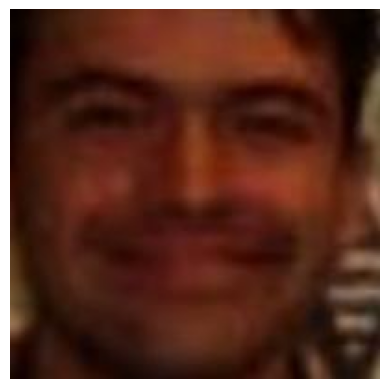

In [7]:
plt.imshow(img_rgb)#padded cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.show()

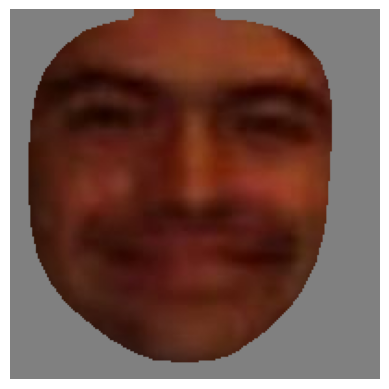

In [8]:
masked_face = get_face_mask(img_rgb)
#print(masked_face)
plt.imshow(masked_face)
plt.axis("off")
plt.show()

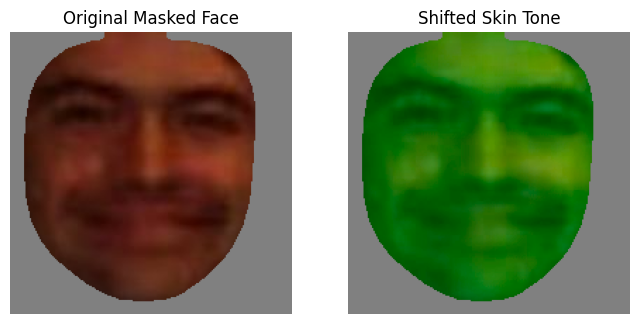

In [ ]:
colored_face_mask = shift_skin_color(masked_face, (0,110,0))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(masked_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(colored_face_mask); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

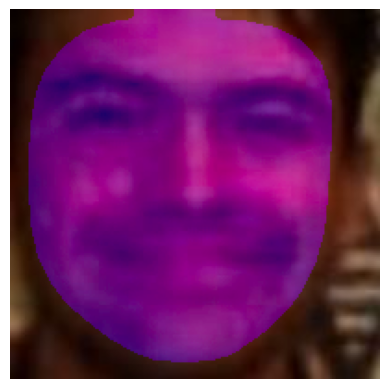

In [9]:
oainted_face = change_face_color(img_bgr, (128, 0, 128))
plt.imshow(oainted_face)
plt.axis("off")
plt.show()

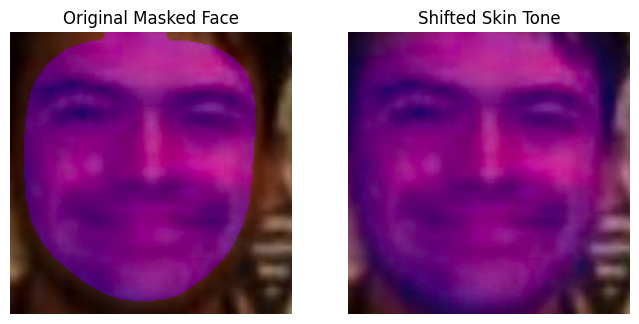

In [5]:
oainted_face = change_face_color(img_bgr, (128, 0, 128))
oainted_face_blur = change_face_color(img = img_bgr, color = (128, 0, 128), smooth = 15)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(oainted_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(oainted_face_blur); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

Problem -> too diff

option 1 (lazy) -> for all images, both normal and altered use only the mask of recognizable face, find the mean of the pixels colors and shift it a little to grey, use this new one as background

option 2 (not so easy) -> the pixels close and on the borderlines gets teir colours mixed. Mimiking a little what the kernel on the CNNs does but applied only on the borders of the face 

| Option                       | Description              | Quality      | Speed   | Complexity | Best For           |
| ---------------------------- | ------------------------ | ------------ | ------- | ---------- | ------------------ |
| 1️⃣ Background harmonization | Shift background color   | 🟡 Medium    | ⚡ Fast  | 🟢 Easy    | Quantitative tests |
| 2a️ Gaussian feather        | Soft transition edges    | 🟢 High      | ⚡ Fast  | 🟢 Easy    | All-rounder        |
| 2b️ Distance fade           | Control fade width       | 🟢 High      | ⚡ Fast  | 🟡 Medium  | Custom look        |
| 2c️ Poisson clone           | Gradient-level blending  | 🟣 Excellent | 🐢 Slow | 🔴 Hard    | Visual realism     |
| 3️⃣ Lightness matching       | Adjust L channel locally | 🟢 High      | ⚡ Fast  | 🟡 Medium  | Natural look       |


In [ ]:
"""
This method takes too much time
...and faild first try
"""

import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

# load the pretrained Stable Diffusion 2.1 model
model_id = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)


# open your input image (replace with your file path)
img_path = "../UTK_filtered/white/29_0_0_20170109002204936.jpg.chip.jpg"#28_0_0_20170104202019890.jpg.chip.jpg 
init_image = Image.open(img_path).convert("RGB")

# the creative prompt
prompt = "the same person but with natural looking green skin, realistic lighting, detailed skin texture, cinematic portrait"

# adjust strength: 0.3–0.6 = subtle; 0.7+ = big change
result = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.5,
    guidance_scale=8.0
).images[0]

#result.save("green_skin_output.png")
#print("✅ Saved output to green_skin_output.png")

plt.imshow(result)
plt.axis("off")
plt.show()


c:\Users\Daniela\Desktop\Fac\M.IA\ano_1\semestre_1\IAS\Projeto_Individual\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Daniela\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...:  17%|█▋        | 1/6 [

: 

| Goal                                 | Method                              | Function                     |
| ------------------------------------ | ----------------------------------- | ---------------------------- |
| Rough face box                       | `face_recognition.face_locations()` | Rectangle mask               |
| Detailed outline                     | `face_recognition.face_landmarks()` | Polygon mask (jawline, etc.) |
| True pixel mask (skin vs background) | Mediapipe / segmentation model      | Requires external library    |


| Method                     | Type                  | Accuracy                                                    | Speed       | Comments                                            |
| -------------------------- | --------------------- | ----------------------------------------------------------- | ----------- | --------------------------------------------------- |
| **Mediapipe Face Mesh**    | Landmark-based        | ✅ Good for face contours, eyes, lips                        | ⚡ Very fast | Doesn’t explicitly label “skin” vs “hair”           |
| **BiSeNet (Face Parsing)** | Semantic segmentation | ⭐ Excellent — directly gives skin, eyes, mouth, hair labels | 🐢 Slower   | Requires model weights, but great for research      |
| **U²-Net / DeepLab**       | General segmentation  | Medium                                                      | Medium      | Not face-specific — can confuse hair and background |


---
# <h1 style="color:olive;"><b> 4 - Test Facial Recogniton of Models</b></h1>

do per model 
- for same colour but diff tonalities
- check the diff clours toghether 
- compare lighter and darker tones
- compare same colours but different races

off all models 
- check ability to predict

---
# <h1 style="color:olive;"><b>5 - RESULTS</b></h1>

---

# <h1 style="color:#89F3EA;"><b>6 - EXTRA </b></h1>

for facial features (try to eval based on shape of: nose, lips, yeys, chin,...)